In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

def get_data(dataset):
    """Read hd5 data files to pandas df"""
    path = f'/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/{dataset}/df_ml_inputs.hd5'
    return pd.read_hdf(path)

def get_obj_features(data):
    # Feature engineering
    object_cols = ['cleanedJet_eta', 'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'cleanedJet_chHEF', 'cleanedJet_area']
    # dict of names
    names = {0:'Leading', 1:'Secondary', 2:'Third', 3:'Fourth'}
    for col in object_cols:
        for jet in range(4):
            name = f'{names[jet]} {col}'
            data[name] = data.apply(lambda x:x[col][jet] if jet < x['ncleanedJet'] else None, axis=1)
    return data

def preprocess(train_size=0.8):
    datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
    # Combine datasets
    data = pd.concat([get_data(dataset) for dataset in datasets], ignore_index=True)
    # Labels (make individual columns of ones and zeros for each category)
    labels = pd.get_dummies(data['dataset'])
    # data = data.join(labels)
    # separate features from labels
    X, y = data.drop(['weight_nominal', 'entry', 'hashed_filename', 'MHT_phi', 'InputMet_phi', 'cleanedJet_phi', 'dataset'], axis=1), labels
    X['BiasedDPhi'] = abs(X['BiasedDPhi'])
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
    weights = [X_train['xs_weight'], X_test['xs_weight']]
    X_train, X_test = X_train.drop('xs_weight', axis=1), X_test.drop('xs_weight', axis=1)
    # Save non scaled train and test for analysis
    # X_train.to_hdf("./X_train_combined.hd5", key="train")
    # X_test.to_hdf("./X_test_combined.hd5", key="test")
    # Feature scaling for event level variables
    X_train_event, X_test_event = X_train.select_dtypes(exclude=object), X_test.select_dtypes(exclude=object)
    event_scaler = StandardScaler()
    X_train_event_scaled = event_scaler.fit_transform(X_train_event)
    X_test_event_scaled = event_scaler.transform(X_test_event)
    # Get object level data
    X_train_obj, X_test_obj = get_object_data(X_train.select_dtypes(object), 14), get_object_data(X_test.select_dtypes(object), 14)
    object_scaler = StandardScaler()
    nz_train, nz_test = np.any(X_train_obj, -1), np.any(X_test_obj, -1)
    X_train_obj[nz_train] = object_scaler.fit_transform(X_train_obj[nz_train])
    X_test_obj[nz_test] = object_scaler.transform(X_test_obj[nz_test])
    np.nan_to_num(X_train_obj, copy=False, nan=0)
    np.nan_to_num(X_test_obj, copy=False, nan=0)
    return np.array([X_train_event_scaled, X_test_event_scaled, X_train_obj, X_test_obj, y_train, y_test]), weights


def get_object_data(inp_data, max_jets):
    num_samples = len(inp_data)
    num_cols = len(inp_data.columns)
    data = np.zeros((num_samples, max_jets, num_cols))
    for i in range(max_jets):
        for j in range(num_cols):
            data[:, i, j] = inp_data.iloc[:, j].map(lambda x: x[i] if len(x) > i else np.nan)
    return data

In [3]:
s = get_data("ttH125")
s.select_dtypes(object).columns

Index(['dataset', 'cleanedJet_area', 'cleanedJet_btagDeepB',
       'cleanedJet_chHEF', 'cleanedJet_eta', 'cleanedJet_mass',
       'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt'],
      dtype='object')

In [8]:
full_data = preprocess()
y_train, y_test = full_data[0][-2], full_data[0][-1]
print(f"""Training ratios:  {len(y_train[y_train['ttH125']==1])/len(y_train)}, {len(y_train[y_train['TTToHadronic']==1])/len(y_train)}, 
{len(y_train[y_train['TTToSemiLeptonic']==1])/len(y_train)}, {len(y_train[y_train['TTTo2L2Nu']==1])/len(y_train)}""")
print(f"""Test ratios:  {len(y_test[y_test['ttH125']==1])/len(y_test)}, {len(y_test[y_test['TTToHadronic']==1])/len(y_test)}, 
{len(y_test[y_test['TTToSemiLeptonic']==1])/len(y_test)}, {len(y_test[y_test['TTTo2L2Nu']==1])/len(y_test)}""")
# np.save("./full_data.npy", full_data[0])
# np.save("./weights.npy", full_data[1])

Training ratios:  0.24281657940503154, 0.0005012577289968427, 
0.7243174184004377, 0.032364744465533946
Test ratios:  0.24281435295555964, 0.0005012531328320802, 
0.7243230026285226, 0.032361391283085766


/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
np.save("./full_data_feb15.npy", full_data[0])
# np.save("./weights.npy", full_data[1])

In [7]:
datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
data = pd.concat([get_data(dataset) for dataset in datasets], ignore_index=True)
labels = pd.get_dummies(data['dataset'])
data = data.join(labels)

In [12]:
train_labels, test_labels = train_test_split(labels, random_state=42, stratify=labels['ttH125'])
train_labels

,TTTo2L2Nu,TTToHadronic,TTToSemiLeptonic,ttH125
130194,0,0,1,0
6136,0,0,0,1
168648,0,0,1,0
311994,0,0,1,0
29682,0,0,0,1
...,...,...,...,...
174931,0,0,1,0
175517,0,0,1,0
98871,0,0,0,1
122727,0,0,1,0


In [14]:
full_data[0][-2]

110193    0
301732    0
305801    0
1769      1
203489    0
         ..
174931    0
175517    0
24248     1
122727    0
78880     1
Name: ttH125, Length: 327177, dtype: uint8

In [6]:
s/np.sqrt(b)

5.470653048352906

In [10]:
full_data = preprocess()

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [3]:
bg_datasets = ['TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
total_xs = []
n_examples = []
for bg in bg_datasets:
    df = get_data(bg)
    xs = df["xs_weight"].sum()
    total_xs.append(xs)
    n_examples.append(len(df))
print(total_xs)
print(n_examples)


[0.30719006, 0.00022454452, 0.01506993]
[296226, 205, 13236]


In [5]:
xs_ratios = [total_xs[i]/sum(total_xs) for i in range(3)]
n_ratios = [n_examples[i]/sum(n_examples) for i in range(3)]
print(xs_ratios)
print(n_ratios)


[0.9525729988784043, 0.0006962954709586545, 0.046730705650637]
[0.9565953104463827, 0.000662001440256792, 0.04274268811336048]


In [ ]:
full_data[0]

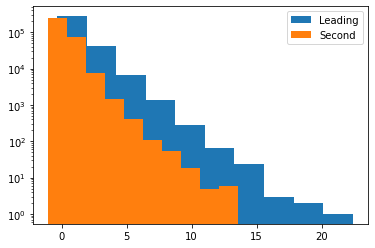

In [7]:
import matplotlib.pyplot as plt

obj_data = full_data[0][2]

#Leading Jet
plt.hist(obj_data[:, 0, -1], log=True, label="Leading")
plt.hist(obj_data[:,1,-1], log=True, label="Second")
plt.legend()
plt.show()

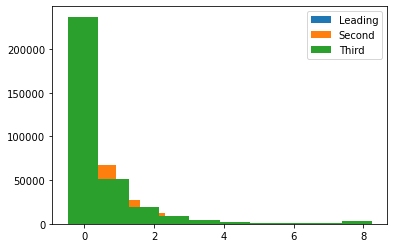

In [12]:
import matplotlib.pyplot as plt

obj_data = full_data[0][2]

# Leading Jet
plt.hist(obj_data[:, 0, -3], label="Leading")
plt.hist(obj_data[:,1,-3], label="Second")
plt.hist(obj_data[:, 2, -3], label="Third")
plt.legend()
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = full_data[0][0], full_data[0][1], full_data[0][-2], full_data[0][-1]
clf = LogisticRegression(random_state=1).fit(X_train, y_train)


In [6]:
scores = clf.predict_proba(X_test)
scores

array([[0.91904858, 0.08095142],
       [0.74095901, 0.25904099],
       [0.81094039, 0.18905961],
       ...,
       [0.95004988, 0.04995012],
       [0.69327869, 0.30672131],
       [0.43327449, 0.56672551]])

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])


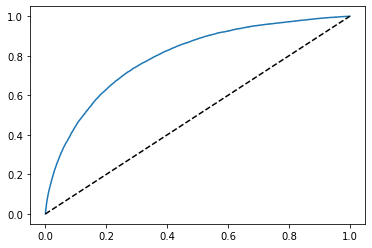

In [11]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0, 1, 100), linestyle="dashed", color="k")
plt.show()

In [13]:
roc_auc_score(y_test, scores[:,1])

0.7951071366216732

In [3]:
datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
data = pd.concat([get_data(dataset) for dataset in datasets], ignore_index=True)
data.columns

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

In [ ]:
np.save('full_data.npy', full_data[0])
np.save('weights.npy', full_data[1])

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential(
    layers.LSTM(32, input_shape=(14, 8)),
    layers.Dense(1, activation='sigmoid')
)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=keras.metrics.BinaryAccuracy(name='accuracy'))
print(model.summary)
# print('Hello world!')

2022-01-26 17:27:35.184367: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-01-26 17:27:35.231176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2022-01-26 17:27:35.237870: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560b0e1bf360 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-26 17:27:35.237906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-26 17:27:35.240060: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module

Traceback (most recent call last):
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_103161/1877610519.py", line 6, in <module>
    layers.Dense(1, activation='sigmoid')
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/sequential.py", line 116, in __init__
    self.add(layer)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/pyth

In [2]:
print(tf.__version__)

2.1.0


In [14]:
obj_train = full_data[0][2]
obj_train[:, 0, 7]



array([ 0.34737535, -0.93513631, -0.87114019, ..., -0.31020072,
       -0.85554891,  3.55868584])

In [5]:
for i in range(14):
    scaler = StandardScaler()
    obj_train[:, i, :] = scaler.fit_transform(obj_train[:, i, :])

In [20]:
import pandas as pd

dataset = 'ttH125'
data = pd.read_hdf(f'/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/{dataset}/df_ml_inputs.hd5')
data.columns
# 8 x 14

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

In [18]:
arr = np.zeros((len(data), 14, 2))
arr[:, 0, 0] = data.iloc[:, 18].map(lambda x:x[2] if len(x) > 2 else 0)
arr


array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.02929688, 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       ...,

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.01293945, 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        .

In [3]:
from sklearn.model_selection import train_test_split

X, y = data.drop('dataset', axis=1), data['dataset']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_train.shape

NameError: name 'data' is not defined

RNN - want sequence of vectors 

In [25]:
data, weights = preprocess(['entry', 'hashed_filename', 'weight_nominal', 'InputMet_phi', 'MHT_phi', 'xs_weight', 'cleanedJet_area', 'cleanedJet_eta',
'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'cleanedJet_btagDeepB', 'cleanedJet_chHEF'])
np.save('full_data_binary', data)
np.save('full_data_xs_weights', weights)

/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
